In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np
import matplotlib.pyplot as plt

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f
from oma_tracking.models.utils import convert_dict

from dotenv import load_dotenv
load_dotenv()

# data selection imports
from xgboost import XGBRegressor
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from hyperopt import Trials
from hyperopt import hp

import warnings
warnings.filterwarnings('ignore')

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

In [3]:
start =  datetime.datetime(2022,10,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,4,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2C02'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
SS1_path = data_root + "data/nw2/tracked_modes/SS1_" + name_location  + ".parquet"
SS2_path = data_root + "data/nw2/tracked_modes/SS2_" + name_location  + ".parquet"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
SS1_tracked = pd.read_parquet(SS1_path)
SS2_tracked = pd.read_parquet(SS2_path)

SS1_sorted = SS1_tracked.sort_values(['timestamp', 'size'])
SS1_sorted[SS1_sorted.index.duplicated(keep='last')]
SS1_drop_duplicates = SS1_sorted[~SS1_sorted.index.duplicated(keep='last')]

SS2_sorted = SS2_tracked.sort_values(['timestamp', 'size'])
SS2_sorted[SS2_sorted.index.duplicated(keep='last')]
SS2_drop_duplicates = SS2_sorted[~SS2_sorted.index.duplicated(keep='last')]

SS1_frequency = SS1_drop_duplicates.frequency
SS2_frequency = SS2_drop_duplicates.frequency

scada_inputs = make_dataset.get_scada_subset(data)
weather_data = mvbc_data[mvbc_data.columns[mvbc_data.isna().sum() < len(mvbc_data) * 0.1]]

inputs = \
    pd.concat(
        [
            weather_data,
            scada_inputs
        ],
        axis=1
    )

selected_columns = \
    [
       #'mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw',
       'mean_NW2_C02_pitch',
       'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed',
       'mean_NW2_C02_winddirection'
    ]
inputs = inputs[selected_columns]

# SS2 model selection

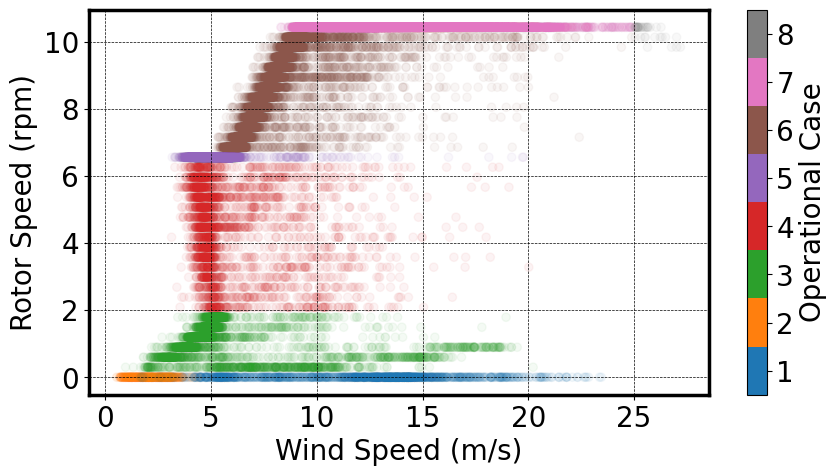

In [4]:
### Multiple Linear Regression
# define the 6 operational cases

inputs['operational_case'] = np.nan

cutout_windspeed = 25
pitch1 = 72
rpm1 = 1.9
rpm2 = 6.5
rpm3 = 6.8
rpm4 = 10.2


# Case 1: parked/idling + pitch > 72
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] <= 0) & (inputs['mean_NW2_C02_pitch'] > pitch1) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    1,
    inputs['operational_case']
)

# Case 2: parked/idling + pitch < 72
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] <= 0) & (inputs['mean_NW2_C02_pitch'] < pitch1) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    2,
    inputs['operational_case']
)

# Case 3: transition1: 0 < rpm < 1.9
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] > 0) & (inputs['mean_NW2_C02_rpm'] < rpm1) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    3,
    inputs['operational_case']
)

# Case 4: transition2: 1.9 < rpm < 6.8
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] > rpm1) & (inputs['mean_NW2_C02_rpm'] < rpm2) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    4,
    inputs['operational_case']
)

# Case 5: start operating: rpm where pitch increases
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] >= rpm2) & (inputs['mean_NW2_C02_rpm'] < rpm3) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    5,
    inputs['operational_case']
)

# Case 6: operating: rpm where pitch increases
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] >= rpm3) & (inputs['mean_NW2_C02_rpm'] < rpm4) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    6,
    inputs['operational_case']
)

# Case 7: operating: rpm > rpm4
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_C02_rpm'] >= rpm4) & (inputs['mean_NW2_C02_windspeed'] < cutout_windspeed),
    7,
    inputs['operational_case']
)

# Case 8: cutout: windspeed > cutout_windspeed
inputs['operational_case'] = np.where(
    inputs['mean_NW2_C02_windspeed'] > cutout_windspeed,
    8,
    inputs['operational_case']
)

import matplotlib

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10, 5))
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])
plt.scatter(inputs['mean_NW2_C02_windspeed'], inputs['mean_NW2_C02_rpm'], alpha=0.05, c=inputs['operational_case'], cmap=cmap)
# Add the colorbar with alpha = 1
cbar = plt.colorbar()
cbar.ax.set_ylabel('Operational Case')
cbar.set_alpha(1)
cbar.draw_all()
tick_locs = np.linspace(int(inputs['operational_case'].min()), int(inputs['operational_case'].max()), int(2 * len(inputs['operational_case'].unique()) -1 ))[1::2]
cbar_tick_label = np.arange(int(inputs['operational_case'].min()), int(inputs['operational_case'].max() + 1))
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(cbar_tick_label)

# Increase the width of the spines
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['top'].set_linewidth(2.5)

plt.grid(True, color='k', linestyle='--', linewidth=0.5)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Rotor Speed (rpm)')
plt.show()

In [5]:
random_state = 24
test_size = 0.2
angle_transformed_inputs = sin_cos_angle_inputs(inputs)
angle_columns = [angle for angle in inputs.columns if ('yaw' in angle or 'winddirection' in angle)]
angle_removed_inputs = inputs.drop(columns=angle_columns)

prediction_param = SS2_frequency.copy()
y = prediction_param.dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=test_size, random_state=random_state)

from sklearn.preprocessing import StandardScaler
def data_preprocessing(X_train, X_test):
    "Apply standard scaling to the data"
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train, X_test
    
X_tr_prep, X_test_prep = data_preprocessing(X_train, X_test) 


7.0
(578, 10) (578,)
R2:  0.08708485838209967 MSE:  0.00024242211914623244
6.0
(6792, 10) (6792,)
R2:  0.4831127152101212 MSE:  9.149608409313214e-05
5.0
(1560, 10) (1560,)
R2:  0.061338430084359796 MSE:  4.8637254880473446e-05
4.0
(2229, 10) (2229,)
R2:  0.17977439846153065 MSE:  0.0004397240952830218
3.0
(3714, 10) (3714,)
R2:  0.7517478631367744 MSE:  4.955173896810309e-05
2.0
(377, 10) (377,)
R2:  0.7803216953666042 MSE:  5.195507089546226e-05
1.0
(1279, 10) (1279,)
R2:  0.68049491715146 MSE:  7.638641006684797e-05
8.0
(6, 10) (6,)
R2:  -9.724157370803633 MSE:  0.01036955196170425
Overall R2:  0.46726474705832693
Overall MSE:  0.0001319091783808478
R2:  0.5836332840432413
R2:  0.578933565653057


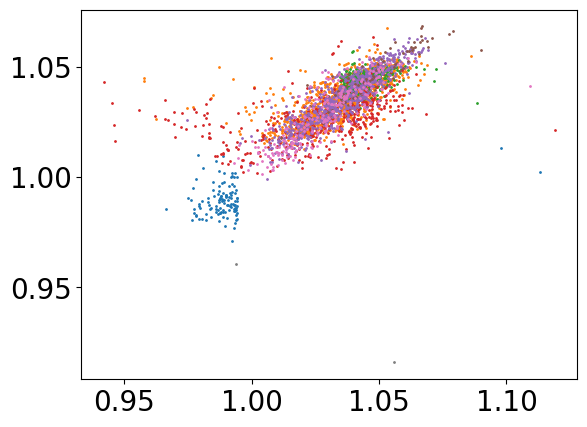

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
mode = 'SS2'
df = inputs.copy().dropna()
random_state = 24
test_size = 0.2

prediction_param = SS2_frequency.copy()

operational_cases = df['operational_case'].unique()

# Train Linear Regression Models for Each Case

linear_regression_models = {}
predictions = {}
r2 = {}
mean_squared_errors = {}
y = prediction_param.dropna()
common_indices = df.index.intersection(y.index)
df_case = df.loc[common_indices]
y_test_cases = {}
predictions_full = {}

for case in operational_cases:
    print(case)
    
    # Filter the dataset for the current operational case
    case_data = df_case[df_case['operational_case'] == case]
    
    # Split the data into input features (X) and target variable (y)
    y = prediction_param.dropna()
    X = case_data.drop(['operational_case'], axis=1).dropna()
    y = y.loc[X.index]
    print(X.shape, y.shape)
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=test_size, random_state=random_state)
    y_test_cases[case] = y_test
    # Train a linear regression model for the current case
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    
    # Store the trained linear regression model for the current case
    linear_regression_models[case] = linear_regression
    predictions[case] = pd.Series(linear_regression_models[case].predict(X_test), index=y_test.index)
    predictions_full[case] = pd.Series(linear_regression_models[case].predict(X), index=y.index)

    r2[case] = r2_score(y_test, predictions[case])
    mean_squared_errors[case] = mean_squared_error(y_test, predictions[case])
    print('R2: ', r2[case], 'MSE: ', mean_squared_errors[case])
    plt.scatter(y_test, predictions[case], alpha=1, s=1)

# Calculate the overall R2 and MSE for the linear regression model through weighted averaging
r2_overall = 0
mse_overall = 0
predictions_ts = pd.Series()
y_test_ts = pd.Series()
predictions_full_ts = pd.Series()
for case in operational_cases:
    r2_overall += r2[case] * len(df_case[df_case['operational_case'] == case])
    mse_overall += mean_squared_errors[case] * len(df_case[df_case['operational_case'] == case])
    predictions_ts = pd.concat([predictions_ts, predictions[case]])
    y_test_ts = pd.concat([y_test_ts, y_test_cases[case]])
    predictions_full_ts = pd.concat([predictions_full_ts, predictions_full[case]])

r2_overall /= len(df_case)
mse_overall /= len(df_case)

print('Overall R2: ', r2_overall)
print('Overall MSE: ',mse_overall)


y = prediction_param.dropna()
X = inputs.copy().drop(['operational_case'], axis=1).loc[y.index].dropna()
y = y.loc[X.index]

predictions_ts.sort_index(inplace=True)
predictions_full_ts.sort_index(inplace=True)
y_test_ts.sort_index(inplace=True)
print('R2: ', r2_score(y_test_ts, predictions_ts))
print('R2: ', r2_score(y, predictions_full_ts))

In [8]:
# Step 3: Import the Required Libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [9]:
mode = 'SS1'
random_state = 24
test_size = 0.2
angle_transformed_inputs = sin_cos_angle_inputs(inputs)
angle_columns = [angle for angle in inputs.columns if ('yaw' in angle or 'winddirection' in angle)]
angle_removed_inputs = inputs.drop(columns=angle_columns)

y = prediction_param.dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=test_size, random_state=random_state)

from sklearn.preprocessing import StandardScaler
def data_preprocessing(X_train, X_test):
    "Apply standard scaling to the data"
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train, X_test
    
X_tr_prep, X_test_prep = data_preprocessing(X_train, X_test) 

y_test_mask = y.isin(y_test_ts)
y_tr_mask = ~y_test_mask
X_tr_ts = X[y_tr_mask]
X_test_ts = X[y_test_mask]
y_tr_ts = y[y_tr_mask]

X_tr_ts_prep, X_test_ts_prep = data_preprocessing(X_tr_ts, X_test_ts)
y_tr_ts_prep, y_test_ts_prep = y_tr_ts.loc[X_tr_ts_prep.index], y_test_ts.loc[X_test_ts_prep.index]

In [10]:
# Initialize the models
linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor()
neural_network = MLPRegressor()
random_forest = RandomForestRegressor()
xgb_regressor = xgb.XGBRegressor()

input_dim = X_train.shape[1]
nn_regressor = Sequential()
nn_regressor.add(Dense(64, activation='relu', input_shape=(input_dim,)))  # Input layer
nn_regressor.add(Dense(64, activation='relu'))  # Hidden layer
nn_regressor.add(Dense(1))  # Output layer

nn_regressor.compile(optimizer='adam', loss='mse')  # Configure the model

# Train the models
linear_regression.fit(X_tr_prep, y_train)
decision_tree.fit(X_train, y_train)
neural_network.fit(X_tr_prep, y_train)
random_forest.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)
nn_regressor.fit(X_tr_prep, y_train, epochs=50, batch_size=32)  # Train the model

# Evaluate the models
linear_regression_pred = linear_regression.predict(X_test_prep)
decision_tree_pred = decision_tree.predict(X_test)
neural_network_pred = neural_network.predict(X_test_prep)
random_forest_pred = random_forest.predict(X_test)
xgb_regressor_pred = xgb_regressor.predict(X_test)
nn_regressor_pred = nn_regressor.predict(X_test_prep)

Epoch 1/50
414/414 [==============================] - 1s 1ms/step - loss: 0.0384
Epoch 2/50
414/414 [==============================] - 1s 1ms/step - loss: 0.0024
Epoch 3/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 4/50
414/414 [==============================] - 1s 1ms/step - loss: 9.5465e-04
Epoch 5/50
414/414 [==============================] - 0s 1ms/step - loss: 7.4881e-04
Epoch 6/50
414/414 [==============================] - 0s 1ms/step - loss: 6.1291e-04
Epoch 7/50
414/414 [==============================] - 0s 1ms/step - loss: 5.3738e-04
Epoch 8/50
414/414 [==============================] - 0s 1ms/step - loss: 5.1496e-04
Epoch 9/50
414/414 [==============================] - 1s 2ms/step - loss: 4.6297e-04
Epoch 10/50
414/414 [==============================] - 1s 1ms/step - loss: 4.3039e-04
Epoch 11/50
414/414 [==============================] - 1s 1ms/step - loss: 4.0757e-04
Epoch 12/50
414/414 [==============================] - 0s 1ms/step - loss: 

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
# Compute the relevant metrics
linear_regression_mse = mean_squared_error(y_test, linear_regression_pred)
decision_tree_mse = mean_squared_error(y_test, decision_tree_pred)
neural_network_mse = mean_squared_error(y_test, neural_network_pred)
random_forest_mse = mean_squared_error(y_test, random_forest_pred)
xgb_regressor_mse = mean_squared_error(y_test, xgb_regressor_pred)
nn_regressor_mse = mean_squared_error(y_test, nn_regressor_pred)

linear_regression_r2 = r2_score(y_test, linear_regression_pred)
decision_tree_r2 = r2_score(y_test, decision_tree_pred)
neural_network_r2 = r2_score(y_test, neural_network_pred)
random_forest_r2 = r2_score(y_test, random_forest_pred)
xgb_regressor_r2 = r2_score(y_test, xgb_regressor_pred)
nn_regressor_r2 = r2_score(y_test, nn_regressor_pred)

# Print the metrics
print("Linear Regression MSE:", linear_regression_mse, "R2:", linear_regression_r2)
print("Decision Tree MSE:", decision_tree_mse, "R2:", decision_tree_r2)
print("Neural Network MSE:", neural_network_mse, "R2:", neural_network_r2)
print("Random Forest MSE:", random_forest_mse, "R2:", random_forest_r2)
print("XGB Regressor MSE:", xgb_regressor_mse, "R2:", xgb_regressor_r2)
print("NN Regressor MSE:", nn_regressor_mse, "R2:", nn_regressor_r2)

Linear Regression MSE: 0.00019607542122388068 R2: 0.404015833263777
Decision Tree MSE: 0.0002639669611352192 R2: 0.1976550227657703
Neural Network MSE: 0.0009904716987483378 R2: -2.010604013342005
Random Forest MSE: 0.00012730171890494007 R2: 0.6130580345456926
XGB Regressor MSE: 0.0001341885802138854 R2: 0.592124965663218
NN Regressor MSE: 0.00017089784297057284 R2: 0.48054474189532026


In [14]:
#Hyperparameter optimization

#Hyperopt functions for hyperparameter optimizations

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from oma_tracking.models.utils import convert_dict
XGB_optimizations = {}

seed = 24
def objective_xgb(space):
    model = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', XGBRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 learning_rate = space['learning_rate'],
                                 colsample_bytree = space['colsample_bytree'],
                                 )
                )
            ]
        )
    score = cross_val_score(model,  X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    # We aim to maximize r2 score, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

def optimize_xgb(trial):
    space = {
        'n_estimators':hp.uniformint('n_estimators',10,1000),
        'max_depth':hp.uniformint('max_depth',2,20),
        'learning_rate':hp.uniform('learning_rate',0.001,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1),
    }
    best = \
        fmin(
            fn = objective_xgb,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 200,
            )
    return best
        
trial2=Trials()
XGB_optimizations[mode] = optimize_xgb(trial2)
XGB_optimizations[mode] = convert_dict(XGB_optimizations)[mode]

100%|██████████| 200/200 [1:53:02<00:00, 33.91s/trial, best loss: 0.00013000767134509496]  


In [15]:
regr_xgb_optimized = \
                Pipeline(
                    steps=[
                        ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                        ('regressor', XGBRegressor(
                            n_estimators = XGB_optimizations[mode]['n_estimators'],
                            max_depth = XGB_optimizations[mode]['max_depth'],
                            learning_rate = XGB_optimizations[mode]['learning_rate'],
                            colsample_bytree = XGB_optimizations[mode]['colsample_bytree'],
                            )
                        )
                    ]
                )

regr_xgb_optimized.fit(X_tr_ts, y_tr_ts)

regr_xgb_optimized_pred = regr_xgb_optimized.predict(X_test_ts)
regr_xgb_optimized_mse = mean_squared_error(y_test_ts, regr_xgb_optimized_pred)
regr_xgb_optimized_r2 = r2_score(y_test_ts, regr_xgb_optimized_pred)
print("XGBRegressor Optimized MSE:", regr_xgb_optimized_mse, "XGBRegressor Optimized R2:", regr_xgb_optimized_r2)

XGBRegressor Optimized MSE: 0.00012152589003249391 XGBRegressor Optimized R2: 0.6234757693583659


In [12]:
# Catboost

import catboost as cb
cb_reg_1 = cb.CatBoostRegressor(task_type='GPU', verbose=200)


cb_reg_1.fit(X_tr_ts, y_tr_ts)
cb_preds = cb_reg_1.predict(X_test_ts)
cb_mse = mean_squared_error(y_test_ts, cb_preds)
cb_r2 = r2_score(y_test_ts, cb_preds)
print("CB MSE:", cb_mse, "CB R2:", cb_r2)

print(cb_reg_1.get_all_params())

Learning rate set to 0.056652
0:	learn: 0.0178811	total: 31.4ms	remaining: 31.4s
200:	learn: 0.0107415	total: 5.53s	remaining: 22s
400:	learn: 0.0102180	total: 12s	remaining: 17.9s
600:	learn: 0.0100794	total: 16.9s	remaining: 11.2s
800:	learn: 0.0098524	total: 22.8s	remaining: 5.65s
999:	learn: 0.0097031	total: 28.8s	remaining: 0us
CB MSE: 0.00012283295539392103 CB R2: 0.6194260826662702
{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'RMSE', 'iterations': 1000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Ordered', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_n

In [13]:
# Catboost

import catboost as cb
cb_reg_1 = cb.CatBoostRegressor(task_type='GPU', random_seed=13, verbose=200)


cb_reg_1.fit(X_tr_ts, y_tr_ts)
cb_preds = cb_reg_1.predict(X_test_ts)
cb_mse = mean_squared_error(y_test_ts, cb_preds)
cb_r2 = r2_score(y_test_ts, cb_preds)
print("CB MSE:", cb_mse, "CB R2:", cb_r2)

print(cb_reg_1.get_all_params())

Learning rate set to 0.056652
0:	learn: 0.0178408	total: 172ms	remaining: 2m 51s
200:	learn: 0.0108989	total: 6.96s	remaining: 27.7s
400:	learn: 0.0104095	total: 12.1s	remaining: 18s
600:	learn: 0.0100599	total: 17.3s	remaining: 11.5s
800:	learn: 0.0097948	total: 22.6s	remaining: 5.62s
999:	learn: 0.0095635	total: 27.8s	remaining: 0us
CB MSE: 0.00011901940078294745 CB R2: 0.6312416366648688
{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'RMSE', 'iterations': 1000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Ordered', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss

In [18]:
import optuna 
def objective_cb(trial):
    params = {
        #"task_type" : "GPU",
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10, log=True),
        "learning_rate": trial.suggest_float("learning_rate",0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        #"subsample": trial.suggest_float("subsample", 0.05, 1.0),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    model.fit(X_tr_ts, y_tr_ts)
    predictions = model.predict(X_test_ts)
    mse = mean_squared_error(y_test_ts, predictions, squared=True)
    return mse

study = optuna.create_study(direction='minimize', study_name='catboost_optimization_SS2')
study.optimize(objective_cb, n_trials=50, n_jobs=-1, timeout=600)

[I 2023-07-19 14:01:35,461] A new study created in memory with name: catboost_optimization_SS2
[I 2023-07-19 14:01:45,188] Trial 6 finished with value: 0.00012983492876014565 and parameters: {'iterations': 886, 'l2_leaf_reg': 0.5482781630146821, 'learning_rate': 0.020307966834131275, 'depth': 2}. Best is trial 6 with value: 0.00012983492876014565.
[I 2023-07-19 14:01:56,989] Trial 3 finished with value: 0.00012115649173575023 and parameters: {'iterations': 614, 'l2_leaf_reg': 2.2110594942079573, 'learning_rate': 0.019807442814429872, 'depth': 6}. Best is trial 3 with value: 0.00012115649173575023.
[I 2023-07-19 14:02:03,368] Trial 2 finished with value: 0.00012402383882721346 and parameters: {'iterations': 1777, 'l2_leaf_reg': 0.6328938569376641, 'learning_rate': 0.011064945995928506, 'depth': 3}. Best is trial 3 with value: 0.00012115649173575023.
[I 2023-07-19 14:02:27,870] Trial 1 finished with value: 0.00012005966410408726 and parameters: {'iterations': 733, 'l2_leaf_reg': 0.444255

In [19]:
print(study.best_value)
print(study.best_params)

0.00011762367551352494
{'iterations': 598, 'l2_leaf_reg': 0.7921575126989409, 'learning_rate': 0.03140108626582761, 'depth': 7}


In [20]:
study.best_params
# Catboost

import catboost as cb
cb_reg_opt = cb.CatBoostRegressor(verbose=200, **study.best_params)


cb_reg_opt.fit(X_tr_ts, y_tr_ts)
cb_preds_opt = cb_reg_opt.predict(X_test_ts)
cb_opt_mse = mean_squared_error(y_test_ts, cb_preds_opt)
cb_opt_r2 = r2_score(y_test_ts, cb_preds_opt)
print("CB MSE:", cb_opt_mse, "CB R2:", cb_opt_r2)

0:	learn: 0.0181087	total: 9.5ms	remaining: 5.67s
200:	learn: 0.0107977	total: 2.11s	remaining: 4.18s
400:	learn: 0.0098894	total: 4.04s	remaining: 1.98s
597:	learn: 0.0092514	total: 6.08s	remaining: 0us
CB MSE: 0.00011762367551352494 CB R2: 0.6355660187625096


In [21]:
#Hyperparameter optimization

#Hyperopt functions for hyperparameter optimizations

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from oma_tracking.models.utils import convert_dict
RF_optimizations = {}

seed = 24
def objective_rf(space):
    model = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', RandomForestRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 min_samples_split = space['min_samples_split'],
                                 )
                )
            ]
        )
    score = cross_val_score(model,  X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    # We aim to maximize r2 score, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

def optimize_rf(trial):
    space = {
        'n_estimators': hp.uniformint('n_estimators',10,500),
        'max_depth': hp.uniformint('max_depth',2,20),
        'min_samples_split': hp.uniformint('min_samples_split',2,20)
    }
    best = \
        fmin(
            fn = objective_rf,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 50,
            )
    return best
        
trial2=Trials()
RF_optimizations[mode] = optimize_rf(trial2)
RF_optimizations[mode] = convert_dict(RF_optimizations)[mode]

 48%|████▊     | 24/50 [1:11:56<2:45:01, 380.83s/trial, best loss: 0.0001360168880996699]

In [ ]:
RF_optimizations[mode] = convert_dict(RF_optimizations)[mode]
regr_rf_optimized = \
                Pipeline(
                    steps=[
                        ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                        ('regressor', RandomForestRegressor(
                            n_estimators = RF_optimizations[mode]['n_estimators'],
                            max_depth = RF_optimizations[mode]['max_depth'],
                            min_samples_split = RF_optimizations[mode]['min_samples_split']
                            )
                        )
                    ]
                )

regr_rf_optimized.fit(X_tr_ts, y_tr_ts)

regr_rf_optimized_pred = regr_rf_optimized.predict(X_test_ts)
regr_rf_optimized_mse = mean_squared_error(y_test_ts, regr_rf_optimized_pred)
regr_rf_optimized_r2 = r2_score(y_test_ts, regr_rf_optimized_pred)
print("RandomForestRegressor Optimized MSE:", regr_rf_optimized_mse, "RandomForestRegressor Optimized R2:", regr_rf_optimized_r2)

RandomForestRegressor Optimized MSE: 5.133582667299477e-06 RandomForestRegressor Optimized R2: 0.5279381408239674


In [ ]:
# Perform Hyperparameter Optimization for TensorFlow Neural Network
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="mean_squared_error",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="nn_1hiddenlayers",
)
tuner.search_space_summary()

tuner.search(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Trial 5 Complete [00h 02m 32s]
mean_squared_error: 5.689666522812331e-06

Best mean_squared_error So Far: 5.2300065362942405e-06
Total elapsed time: 00h 12m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Perform Hyperparameter Optimization for TensorFlow Neural Network
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model

tuner2 = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="mean_squared_error",
    max_trials=6,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="nn_2hiddenlayers",
)
tuner2.search_space_summary()

tuner2.search(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Trial 6 Complete [00h 02m 25s]
mean_squared_error: 5.104195452076965e-06

Best mean_squared_error So Far: 4.914184728477267e-06
Total elapsed time: 00h 16m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Perform Hyperparameter Optimization for TensorFlow Neural Network
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model

tuner3 = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="mean_squared_error",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="nn_3hiddenlayers",
)
tuner3.search_space_summary()

tuner3.search(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Trial 5 Complete [00h 03m 15s]
mean_squared_error: 4.991580681235064e-06

Best mean_squared_error So Far: 4.938730853609741e-06
Total elapsed time: 00h 14m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(input_shape=(1, X_tr_ts_prep.shape[1]))
best_model.fit(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Epoch 1/100
506/506 [==============================] - 1s 1ms/step - loss: 5.3319e-06 - mean_squared_error: 5.3319e-06 - val_loss: 5.5327e-06 - val_mean_squared_error: 5.5327e-06
Epoch 2/100
506/506 [==============================] - 1s 2ms/step - loss: 5.3318e-06 - mean_squared_error: 5.3318e-06 - val_loss: 5.4545e-06 - val_mean_squared_error: 5.4545e-06
Epoch 3/100
506/506 [==============================] - 1s 1ms/step - loss: 5.2799e-06 - mean_squared_error: 5.2799e-06 - val_loss: 5.5643e-06 - val_mean_squared_error: 5.5643e-06
Epoch 4/100
506/506 [==============================] - 1s 1ms/step - loss: 5.2573e-06 - mean_squared_error: 5.2573e-06 - val_loss: 5.4831e-06 - val_mean_squared_error: 5.4831e-06
Epoch 5/100
506/506 [==============================] - 1s 1ms/step - loss: 5.2644e-06 - mean_squared_error: 5.2644e-06 - val_loss: 5.5270e-06 - val_mean_squared_error: 5.5270e-06
Epoch 6/100
506/506 [==============================] - 1s 2ms/step - loss: 5.2845e-06 - mean_squared_erro

In [ ]:
nn1_opt_pred = best_model.predict(X_test_ts_prep)
nn1_opt_mse = mean_squared_error(y_test_ts_prep, nn1_opt_pred)
nn1_opt_r2 = r2_score(y_test_ts_prep, nn1_opt_pred)
print("NN2 Optimized MSE:", nn1_opt_mse, "NN2 Optimized R2:", nn1_opt_r2)

NN2 Optimized MSE: 5.453459152085495e-06 NN2 Optimized R2: 0.4985236952211627


In [ ]:
best_model2 = tuner2.get_best_models()[0]
best_model2.build(input_shape=(1, X_tr_ts_prep.shape[1]))
best_model2.fit(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Epoch 1/100
506/506 [==============================] - 1s 1ms/step - loss: 4.8832e-06 - mean_squared_error: 4.8832e-06 - val_loss: 5.3439e-06 - val_mean_squared_error: 5.3439e-06
Epoch 2/100
506/506 [==============================] - 1s 1ms/step - loss: 4.9166e-06 - mean_squared_error: 4.9166e-06 - val_loss: 5.3992e-06 - val_mean_squared_error: 5.3992e-06
Epoch 3/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8699e-06 - mean_squared_error: 4.8699e-06 - val_loss: 5.3527e-06 - val_mean_squared_error: 5.3527e-06
Epoch 4/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8931e-06 - mean_squared_error: 4.8931e-06 - val_loss: 6.5657e-06 - val_mean_squared_error: 6.5657e-06
Epoch 5/100
506/506 [==============================] - 1s 2ms/step - loss: 4.9039e-06 - mean_squared_error: 4.9039e-06 - val_loss: 5.3466e-06 - val_mean_squared_error: 5.3466e-06
Epoch 6/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8392e-06 - mean_squared_erro

In [ ]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 13)                0         
                                                                 
 dense (Dense)               (None, 120)               1680      
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 16,321
Trainable params: 16,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn2_opt_pred = best_model2.predict(X_test_ts_prep)
nn2_opt_mse = mean_squared_error(y_test_ts_prep, nn2_opt_pred)
nn2_opt_r2 = r2_score(y_test_ts_prep, nn2_opt_pred)
print("NN2 Optimized MSE:", nn2_opt_mse, "NN2 Optimized R2:", nn2_opt_r2)

NN2 Optimized MSE: 5.572620411625559e-06 NN2 Optimized R2: 0.4875661458125289


In [ ]:
best_model3 = tuner3.get_best_models()[0]
best_model3.build(input_shape=(1, X_tr_ts_prep.shape[1]))
best_model3.fit(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

Epoch 1/100
506/506 [==============================] - 1s 2ms/step - loss: 4.9069e-06 - mean_squared_error: 4.9069e-06 - val_loss: 5.4235e-06 - val_mean_squared_error: 5.4235e-06
Epoch 2/100
506/506 [==============================] - 1s 1ms/step - loss: 4.9366e-06 - mean_squared_error: 4.9366e-06 - val_loss: 5.4725e-06 - val_mean_squared_error: 5.4725e-06
Epoch 3/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8739e-06 - mean_squared_error: 4.8739e-06 - val_loss: 5.7118e-06 - val_mean_squared_error: 5.7118e-06
Epoch 4/100
506/506 [==============================] - 1s 2ms/step - loss: 4.9350e-06 - mean_squared_error: 4.9350e-06 - val_loss: 5.4398e-06 - val_mean_squared_error: 5.4398e-06
Epoch 5/100
506/506 [==============================] - 1s 2ms/step - loss: 4.8809e-06 - mean_squared_error: 4.8809e-06 - val_loss: 6.0955e-06 - val_mean_squared_error: 6.0955e-06
Epoch 6/100
506/506 [==============================] - 1s 1ms/step - loss: 4.8821e-06 - mean_squared_erro

In [ ]:
nn3_opt_pred = best_model3.predict(X_test_ts_prep)
nn3_opt_mse = mean_squared_error(y_test_ts_prep, nn3_opt_pred)
nn3_opt_r2 = r2_score(y_test_ts_prep, nn3_opt_pred)
print("NN2 Optimized MSE:", nn3_opt_mse, "NN2 Optimized R2:", nn3_opt_r2)

NN2 Optimized MSE: 5.898300377274987e-06 NN2 Optimized R2: 0.4576180374358635
